## Sandcamera ML model

This notebook builds, trains, and quantized the SandCamera ML model.There are XX general steps

- First - build the network, which is inspired by SediNet (Buscombe 2019)
- Second - train the model
- Third - use Quantization Aware Training to reduce the weights, biases in the model to 8 bits, except for the final Dense classification layers, which are kept at 32 floating point. (This allows for better prediction for regression problems.)
- Fourth - convert the model to TensorFlow Lite format and test the output
- Fifth - link to tools to compile the model for Google Coral EdgeTPU

In [1]:
# import the general stuff
import os
from os import getcwd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd 
import numpy as np

#If multiple GPU, set which GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.2


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#build data generators for training and validaton

#split is 70/20/10 for 300 images, so XX 210 image, 60 images, 30 images.. 
#the 30 have been removed for testing already, so its 22.23% of teh remaining images as validation

traindf = pd.read_csv('../data/SedMLdataTr.csv')
valdf = pd.read_csv('../data/SedMLdataVal.csv')
testdf = pd.read_csv('../data/SedMLdataTest.csv')

columns=["D2mm", "D5mm", "D10mm", "D16mm",
"D25mm","D50mm", "D75mm", "D84mm", "D90mm",
"D95mm", "D98mm"]


# Define dirs and files
train_data_dir = '../data/CropPicsTr'
val_data_dir = '../data/CropPicsVal'
test_data_dir = '../data/CropPicsTest'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   fill_mode = 'reflect')

val_datagen = ImageDataGenerator(rescale = 1./255.)

test_datagen = ImageDataGenerator(rescale = 1./255.)


#set batch Size
batch_size = 8

#set color
# c_ch = 1
# c_mode = 'grayscale'
c_ch = 3
c_mode = 'rgb'

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim, pix_dim) 
imshape = (pix_dim, pix_dim, c_ch)

# Flow training images in batches 
train_generator = train_datagen.flow_from_dataframe(dataframe = traindf,
                                                    directory = train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'CropName',
                                                    y_col = columns,
                                                    target_size = imsize,
                                                    color_mode = c_mode)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_dataframe(dataframe=valdf,
                                                          directory = val_data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = c_mode)

# Flow validation images in batches 
test_generator =  test_datagen.flow_from_dataframe(dataframe = testdf,
                                                          directory = test_data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = c_mode)

Found 210 validated image filenames.
Found 60 validated image filenames.
Found 30 validated image filenames.


Stats : [0.164 0.191 0.218 0.246 0.286 0.435 0.994 1.579 2.193 3.171 4.055]


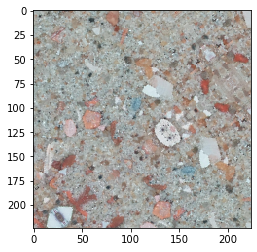

In [4]:
#show augs

how_many = 1
#how_many = batch size

x = train_generator.next()

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    plt.imshow(image.squeeze())   #squeeze for grayscale images
    print('Stats :', x[1][i])
    plt.show()

In [5]:
#load or build model
##########

#from scratch:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

# to freeze the batch Norm layers
base_model.training = False

#base model not trainable
base_model.trainable = False

# add a new classifcation layer
final_layer = base_model.get_layer('out_relu')
#print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output

# add avg pool
x = layers.GlobalAveragePooling2D()(final_base_output)
#add a dense
x = layers.Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final linear layer for classification
x = layers.Dense(len(columns), activation='relu')(x) 


model = Model(base_model.input, x) 
#############
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [6]:
# define other metrics
MAE = tf.keras.metrics.MeanAbsoluteError(name='mae')
MSE = tf.keras.metrics.MeanSquaredError(name='mse')


In [7]:
#compile
#by plotting a loss curve, min occurs w/ Adam() at lr = 1e-2. but i am gettign better results by using default lr.

model.compile(loss = tf.keras.losses.MeanAbsolutePercentageError(), 
              optimizer=tf.keras.optimizers.RMSprop(lr = 1e-4), 
              metrics = [MAE, MSE]
             )

In [8]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 40, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.2,
                                                 verbose = 1,
                                                 patience = 5)

In [9]:
#train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 200,
                    workers = 24,
                    callbacks =[early_stop, reduce_lr])



Epoch 1/200
27/27 [==============================] - 1s 38ms/step - loss: 102.1978 - mae: 0.6559 - mse: 1.0910 - val_loss: 93.4720 - val_mae: 0.5647 - val_mse: 0.7852
Epoch 2/200
27/27 [==============================] - 1s 21ms/step - loss: 94.0505 - mae: 0.5912 - mse: 0.8819 - val_loss: 86.3206 - val_mae: 0.4706 - val_mse: 0.5185
Epoch 3/200
27/27 [==============================] - 0s 18ms/step - loss: 91.6075 - mae: 0.5457 - mse: 0.7035 - val_loss: 88.7085 - val_mae: 0.4699 - val_mse: 0.4740
Epoch 4/200
27/27 [==============================] - 1s 21ms/step - loss: 87.9146 - mae: 0.5049 - mse: 0.5838 - val_loss: 85.1721 - val_mae: 0.4301 - val_mse: 0.3938
Epoch 5/200
27/27 [==============================] - 0s 18ms/step - loss: 86.9492 - mae: 0.4860 - mse: 0.5375 - val_loss: 85.0498 - val_mae: 0.4229 - val_mse: 0.3581
Epoch 6/200
27/27 [==============================] - 0s 18ms/step - loss: 87.4445 - mae: 0.4871 - mse: 0.5507 - val_loss: 84.9408 - val_mae: 0.4104 - val_mse: 0.3283
Epo

Epoch 94/200
27/27 [==============================] - 0s 17ms/step - loss: 31.0139 - mae: 0.2609 - mse: 0.3560 - val_loss: 22.2150 - val_mae: 0.1834 - val_mse: 0.1899
Epoch 95/200
27/27 [==============================] - 0s 17ms/step - loss: 32.4773 - mae: 0.2592 - mse: 0.3258 - val_loss: 22.2149 - val_mae: 0.1834 - val_mse: 0.1899
Epoch 96/200
27/27 [==============================] - 0s 18ms/step - loss: 32.3465 - mae: 0.2689 - mse: 0.3478 - val_loss: 22.2150 - val_mae: 0.1834 - val_mse: 0.1899
Epoch 97/200
27/27 [==============================] - 1s 19ms/step - loss: 31.6145 - mae: 0.2605 - mse: 0.3523 - val_loss: 22.2148 - val_mae: 0.1834 - val_mse: 0.1899
Epoch 98/200
27/27 [==============================] - ETA: 0s - loss: 31.7954 - mae: 0.2591 - mse: 0.3275
Epoch 00098: ReduceLROnPlateau reducing learning rate to 1.279999928271991e-09.
27/27 [==============================] - 0s 17ms/step - loss: 31.7954 - mae: 0.2591 - mse: 0.3275 - val_loss: 22.2147 - val_mae: 0.1834 - val_mse:

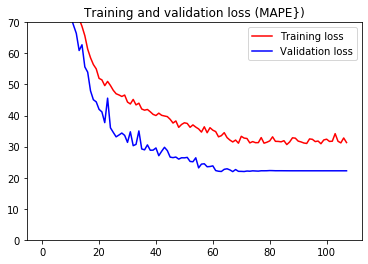

<Figure size 432x288 with 0 Axes>

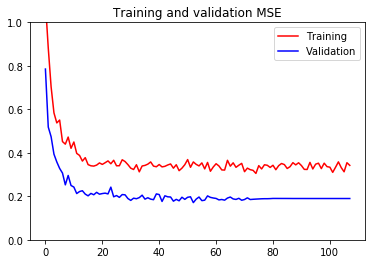

<Figure size 432x288 with 0 Axes>

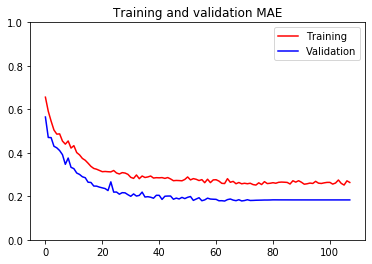

<Figure size 432x288 with 0 Axes>

In [10]:
#look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,70)

plt.title('Training and validation loss (MAPE})')
plt.legend(loc=0)
plt.figure()
plt.show()

mse = history.history['mse']
val_mse = history.history['val_mse']

plt.plot(epochs, mse, 'r', label='Training')
plt.plot(epochs, val_mse, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MSE')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs, mae, 'r', label='Training')
plt.plot(epochs, val_mae, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MAE')
plt.legend(loc=0)
plt.figure()
plt.show()



In [11]:
#evaluate full model on test set:
model.evaluate(test_generator)

4/4 [==============================] - 0s 33ms/step - loss: 20.7406 - mae: 0.1556 - mse: 0.2121


[20.740619659423828, 0.1555538773536682, 0.21205496788024902]

Stats : [0.187 0.216 0.248 0.282 0.332 0.499 0.808 0.955 1.098 1.296 1.588]
Predicted Stats: [[0.20533171 0.21259621 0.20702526 0.2081228  0.31846374 0.46909645
  0.6021052  0.6969303  0.6847616  0.87237555 1.1078132 ]]


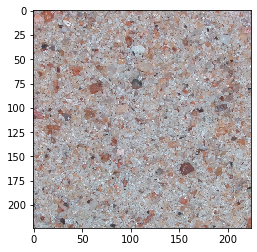

In [12]:
# use the validation generator as a sanity check

x = validation_generator.next()

how_many = 1
#how_many = batch_size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [13]:
#save the model
filepath = './models/SNmodel_MN2'
model.save(filepath)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/SNmodel_MN2/assets


In [ ]:
#reload model, if needed
model = tf.keras.models.load_model('./models/SNmodel_MN2')
model.summary()

In [14]:
#quantize all layers but dense iwth not isinstance

# Helper function  to annotate all non dense layters
def apply_quantization_to_not_dense(layer):
  if not isinstance(layer, (tf.keras.layers.Dense,tf.keras.layers.Dropout)):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# to the layers of the model.
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function = apply_quantization_to_not_dense,
)


# Now that non- Dense layers are annotated,
# `quantize_apply` actually makes the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_Conv1_pad (QuantizeWrappe (None, 225, 225, 3)  1           quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_Conv1 (QuantizeWrapperV2) (None, 112, 112, 32) 929         quant_Conv1_pad[0][0]            
_______________________________________________________________________________________

In [15]:
#delete old model
del model
del annotated_model

In [16]:
# `quantize_model` requires a recompile.
quant_aware_model.compile(loss = tf.keras.losses.MeanAbsolutePercentageError(), 
              optimizer=tf.keras.optimizers.Adam(lr = 0.0001), 
              metrics = [MAE, MSE]
             )

#retrain with low learning rate:

quant2_history = quant_aware_model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 40,
                    workers = 8,
                    callbacks =[early_stop, reduce_lr])


Epoch 1/40
27/27 [==============================] - 6s 215ms/step - loss: 62.1629 - mae: 0.4101 - mse: 0.6288 - val_loss: 36.7641 - val_mae: 0.3002 - val_mse: 0.4380
Epoch 2/40
27/27 [==============================] - 5s 181ms/step - loss: 40.8018 - mae: 0.3838 - mse: 0.6311 - val_loss: 33.8202 - val_mae: 0.3069 - val_mse: 0.4237
Epoch 3/40
27/27 [==============================] - 5s 183ms/step - loss: 38.4442 - mae: 0.3480 - mse: 0.5515 - val_loss: 24.9032 - val_mae: 0.2511 - val_mse: 0.3496
Epoch 4/40
27/27 [==============================] - 5s 181ms/step - loss: 35.8881 - mae: 0.3193 - mse: 0.4660 - val_loss: 48.1654 - val_mae: 0.3924 - val_mse: 0.5251
Epoch 5/40
27/27 [==============================] - 5s 182ms/step - loss: 38.7226 - mae: 0.3544 - mse: 0.5499 - val_loss: 35.1968 - val_mae: 0.3208 - val_mse: 0.4300
Epoch 6/40
27/27 [==============================] - 5s 178ms/step - loss: 34.3452 - mae: 0.3272 - mse: 0.5130 - val_loss: 24.3898 - val_mae: 0.2310 - val_mse: 0.3161
Epoc

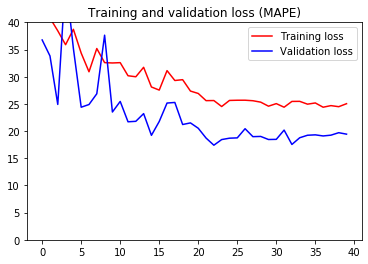

<Figure size 432x288 with 0 Axes>

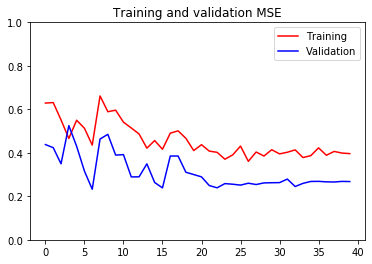

<Figure size 432x288 with 0 Axes>

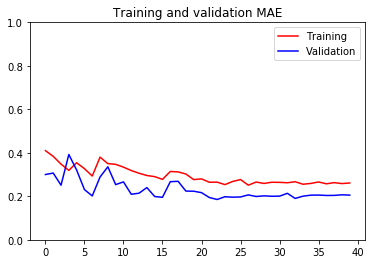

<Figure size 432x288 with 0 Axes>

In [17]:
#look at the metrics from QAT 
%matplotlib inline

loss = quant2_history.history['loss']
val_loss = quant2_history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,40)

plt.title('Training and validation loss (MAPE)')
plt.legend(loc=0)
plt.figure()
plt.show()

mse = quant2_history.history['mse']
val_mse = quant2_history.history['val_mse']

plt.plot(epochs, mse, 'r', label='Training')
plt.plot(epochs, val_mse, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MSE')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = quant2_history.history['mae']
val_mae = quant2_history.history['val_mae']

plt.plot(epochs, mae, 'r', label='Training')
plt.plot(epochs, val_mae, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MAE')
plt.legend(loc=0)
plt.figure()
plt.show()

In [18]:
#evaluate full model on test set:
quant_aware_model.evaluate(test_generator)

4/4 [==============================] - 0s 42ms/step - loss: 17.9125 - mae: 0.1703 - mse: 0.2637


[17.91254997253418, 0.17034712433815002, 0.2637266516685486]

Stats : [0.239 0.282 0.328 0.371 0.429 0.605 0.832 0.946 1.056 1.216 1.403]
Predicted Stats: [[0.17114383 0.2073628  0.24036258 0.26303622 0.30272132 0.43711525
  0.647751   0.754189   0.8632208  0.9860192  1.1519982 ]]


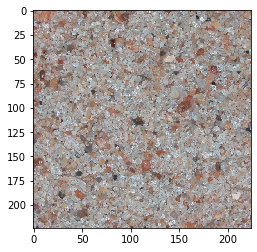

In [19]:
# use the validation generator as a sanity check

x = validation_generator.next()

how_many = 1
#how_many = batch_size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = quant_aware_model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [20]:
#TF lite converter for the QAT model

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model2 = converter.convert()


tflite_models_dir = pathlib.Path("TFL_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"SandCam_MNv2_QAT_notdense.tflite"
tflite_model_file.write_bytes(quantized_tflite_model2)

!ls -lh {tflite_models_dir}

INFO:tensorflow:Assets written to: /tmp/tmpxq31s51o/assets
total 5.2M
drwxrwxr-x 2 ebgoldstein ebgoldstein 4.0K Feb 10 12:44 older
-rw-rw-r-- 1 ebgoldstein ebgoldstein 5.2M Feb 10 13:12 SandCam_MNv2_QAT_notdense.tflite


In [21]:
#Load QAT model into TFlite intepreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

Stats : [0.151 0.167 0.182 0.195 0.211 0.25  0.299 0.326 0.353 0.392 0.445]
Predicted Stats: [[0.10709377 0.12543012 0.14200112 0.17163359 0.17577909 0.23217371
  0.28309882 0.3373285  0.35561526 0.3888489  0.49476954]]


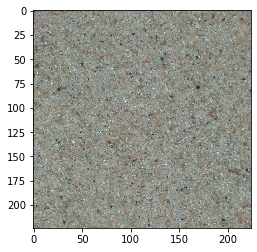

In [22]:
#Sanity check on image 

#SET THE IMAGE
Timage = validation_generator.next()
test_image = np.expand_dims(Timage[0][1],axis=0)

#dynamic range quant
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictionsQAT = interpreter.get_tensor(output_index)

plt.imshow(Timage[0][1])

print('Stats :',Timage[1][1])
print('Predicted Stats:', predictionsQAT)

plt.grid(False)

In [23]:
testdf = pd.read_csv('../data/SedMLdataTest.csv')
test_data_dir = '../data/CropPicsTest'
testdf = testdf.reset_index()  # make sure indexes pair with number of rows
testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,skew,kurtosis
0,0,F7crop21.jpg,0.086,0.103,0.118,0.133,0.154,0.220,0.526,1.143,2.593,4.717,4.763,0.568,1.273
1,1,F7crop22.jpg,0.170,0.189,0.207,0.224,0.245,0.299,0.364,0.398,0.430,0.474,0.529,0.001,0.955
2,2,F7crop23.jpg,0.145,0.170,0.195,0.217,0.245,0.325,0.456,0.558,0.677,0.810,0.991,0.154,1.029
3,3,F7crop24.jpg,0.169,0.193,0.217,0.241,0.272,0.354,0.468,0.557,0.681,0.870,1.074,0.138,1.134
4,4,F7crop25.jpg,0.148,0.164,0.179,0.191,0.205,0.240,0.281,0.304,0.326,0.357,0.396,0.025,1.011


In [24]:
#Load QAT model into TFlite intepreter
tflite_models_dir = pathlib.Path("TFL_models/")
tflite_model_file = tflite_models_dir/"SandCam_MNv2_QAT_notdense.tflite"
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

Stats : [0.17 0.18899999999999997 0.207 0.22399999999999998 0.245 0.299 0.364
 0.39799999999999996 0.43 0.474]
Predicted Stats: [[0.09922178 0.11480257 0.135979   0.16290045 0.16505891 0.21966714
  0.2667776  0.32145727 0.3377142  0.36921412 0.47030386]]


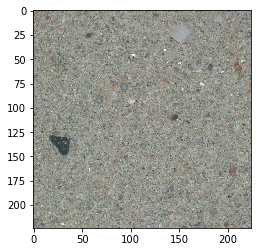

In [25]:
#Sanity check on a single image 
pix_dim = 224
imsize = (pix_dim, pix_dim) 

#SET THE IMAGE
imgp = "../data/CropPicsTest/F7crop21.jpg"
img = tf.keras.preprocessing.image.load_img(imgp,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
test_image = np.expand_dims(img,axis=0)

#set up tensors and rpedict
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictionsQAT = interpreter.get_tensor(output_index)

#show results
plt.imshow(img)

print('Stats :', testdf.iloc[1,2:12].values )
print('Predicted Stats:', predictionsQAT)

plt.grid(False)

In [26]:
#Evaluate on all images:
# 1. loop over all rows in data frame
# 2. grab image path
# 3. evaluate image w/ TFLite
# 4. write output to df
# 5. make plot

# fn to do tflite prediction
def TFLitePred (imgpath):
    pix_dim = 224
    imsize = (pix_dim, pix_dim) 
    #SET THE IMAGE
    img = tf.keras.preprocessing.image.load_img(imgpath,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    test_image = np.expand_dims(img,axis=0)

    #set up tensors and rpedict
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    interpreter.set_tensor(input_index, test_image)
    interpreter.invoke()
    predictionsQAT = interpreter.get_tensor(output_index)
    
    return predictionsQAT
    

In [27]:
#mmake an empty dictionary to hold predictions
pred_dict = []

## loop over all rows in data frame, grab image path, evaluate image w/ TFLite helper fn, 
# then flatten results adn append ot the dictionary
for index, row in testdf.iterrows():
    imgpath = "../data/CropPicsTest/" + row['CropName']
    pred = TFLitePred (imgpath).flatten()
    pred_dict.append(pred)
    #print(pred)

#turn dicitonary into dataframe, add columns, and add to the test df
predictions = pd.DataFrame.from_dict(pred_dict)
predictions.columns=["pD2mm", "pD5mm", "pD10mm", "pD16mm",
"pD25mm","pD50mm", "pD75mm", "pD84mm", "pD90mm",
"pD95mm", "pD98mm"]
predictions.head()

testdf = testdf.join(predictions)

testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,...,pD5mm,pD10mm,pD16mm,pD25mm,pD50mm,pD75mm,pD84mm,pD90mm,pD95mm,pD98mm
0,0,F7crop21.jpg,0.086,0.103,0.118,0.133,0.154,0.220,0.526,1.143,...,0.114803,0.135979,0.162900,0.165059,0.219667,0.266778,0.321457,0.337714,0.369214,0.470304
1,1,F7crop22.jpg,0.170,0.189,0.207,0.224,0.245,0.299,0.364,0.398,...,0.157032,0.170363,0.201247,0.213095,0.284909,0.356176,0.419904,0.466531,0.508312,0.631831
2,2,F7crop23.jpg,0.145,0.170,0.195,0.217,0.245,0.325,0.456,0.558,...,0.182684,0.201930,0.239344,0.266293,0.364324,0.497716,0.597693,0.670456,0.753845,0.915489
3,3,F7crop24.jpg,0.169,0.193,0.217,0.241,0.272,0.354,0.468,0.557,...,0.191762,0.208887,0.250858,0.283867,0.402382,0.567135,0.682554,0.773373,0.865300,1.048056
4,4,F7crop25.jpg,0.148,0.164,0.179,0.191,0.205,0.240,0.281,0.304,...,0.125317,0.141656,0.170891,0.179466,0.232722,0.284463,0.339030,0.360683,0.392141,0.497162


(0, 2)

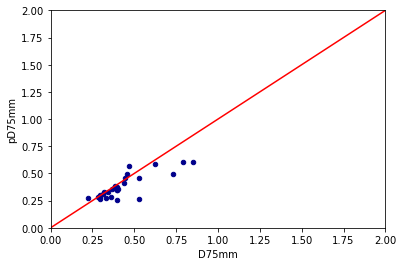

In [28]:
#make a single observed vs predicted plot

ax1 = testdf.plot.scatter(x='D5mm', y='pD75mm', c='DarkBlue')

line = mlines.Line2D([0, 4], [0, 4], color='red')
ax1.add_line(line)
ax1.set_xlim([0,2])
ax1.set_ylim([0,2])

In [29]:
#plot of mean absolute percent error for all range bins

error = pd.DataFrame(100*abs(testdf.iloc[:,2:13].values - predictions.values)/testdf.iloc[:,2:13].values)


error.columns = columns
error.head()

,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm
0,15.374164,11.458805,15.236438,22.481540,7.181111,0.151302,49.281824,71.876005,86.975928,92.172692,90.125890
1,23.721903,16.914437,17.699001,10.157653,13.022561,4.712815,2.149527,5.503479,8.495576,7.238753,19.438762
2,10.965577,7.461433,3.553961,10.296788,8.691065,12.099739,9.148228,7.113424,0.966645,6.932690,7.619717
3,6.204420,0.641682,3.738663,4.090374,4.362759,13.667152,21.182624,22.541029,13.564318,0.540257,2.415631
4,26.098003,23.587500,20.862314,10.528420,12.455511,3.032457,1.232423,11.523104,10.638946,9.843513,25.546061


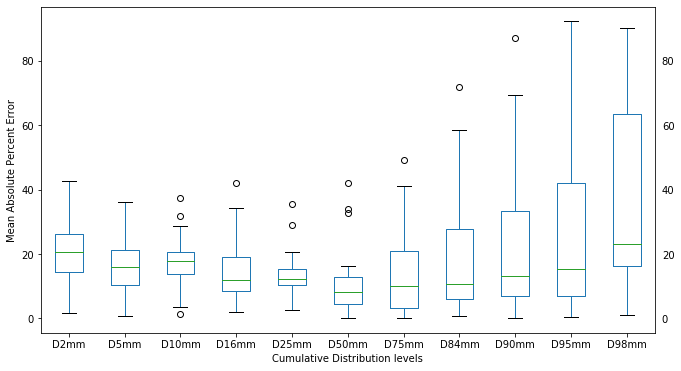

In [30]:
ax = error.plot.box(figsize = [11,6])
ax.set_ylabel('Mean Absolute Percent Error')
ax.set_xlabel('Cumulative Distribution levels')
ax. tick_params(labelright=True)

In [ ]:
#compile the tflite model for edge tpu via: 
#https://github.com/google-coral/tutorials/blob/master/compile_for_edgetpu.ipynb
#https://colab.research.google.com/github/google-coral/tutorials/blob/master/compile_for_edgetpu.ipynb